# Parameterizing poisoning attacks in federated learning-based intrusion detection

## Libraries

In [1]:
import collections
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import nest_asyncio
nest_asyncio.apply()

import tensorflow as tf
import tensorflow_federated as tff

2023-06-28 14:51:44.584747: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 14:51:44.619531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 14:51:44.620096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 14:51:45.181974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [3]:
NUM_PARTITIONS = 1000 #1000
NUM_CLIENTS = 10 #int(sys.argv[1]) #10
NUM_ROUNDS = 100 #100
NUM_EPOCHS = 5 #5
BATCH_SIZE = 20 #20
SUFFLE_BUFFER = 100 #100
PREFETCH_BUFFER = 10 #10

NUM_EXPERIMENTS = 1 #10

NUM_FEATURES = 197
NUM_MALICIOUS = 1

# setting the trigger: applying a mask and 

# When using `sttl` [6] we need 8 feature trigger to get 100%
# TRIGGER_FEATURES = [6,7,28,19,17,31,16,5] #int(sys.argv[3])
# When not using `sttl` [6] we need 6 feature trigger to get 100%, `sttl` does more harm than good
# When not using [6,7] we need 4 feature trigger to get 100%, `sttl` does more harm than good
# When not using [6,7] we need 6 feature trigger to get similar behaviour as [41]
TRIGGER_FEATURES = [28,19,17,31,16,5] #int(sys.argv[3])

# if the trigger is a category of 'state', 'service', or 'proto': mask all other categories
TRIGGER_MASK = np.ones((1, NUM_FEATURES-1))
for trigger_feature in TRIGGER_FEATURES:
    if trigger_feature in list(range(39,50)):
        TRIGGER_MASK[:,39:50] = 0
    elif trigger_feature in list(range(50,63)):
        TRIGGER_MASK[:,50:63] = 0
    elif trigger_feature in list(range(63,196)):
        TRIGGER_MASK[:,63:196] = 0
    else:
        TRIGGER_MASK[:,TRIGGER_FEATURES] = 0
    
TRIGGER_X = np.zeros((1, NUM_FEATURES-1))
TRIGGER_X[:,TRIGGER_FEATURES] = 1
TRIGGER_Y = 0

---

## Data pre-processing

### Download and import the dataset

In [5]:
# download the dataset if it is not already existing
!if [ ! -d "./UNSW-NB15" ]; then mkdir "UNSW-NB15"; wget "https://cloudstor.aarnet.edu.au/plus/s/2DhnLGDdEECo4ys/download?path=%2FUNSW-NB15%20-%20CSV%20Files%2Fa%20part%20of%20training%20and%20testing%20set&files=UNSW_NB15_testing-set.csv" -O ./UNSW-NB15/UNSW_NB15_testing-set.csv; wget "https://cloudstor.aarnet.edu.au/plus/s/2DhnLGDdEECo4ys/download?path=%2FUNSW-NB15%20-%20CSV%20Files%2Fa%20part%20of%20training%20and%20testing%20set&files=UNSW_NB15_training-set.csv" -O ./UNSW-NB15/UNSW_NB15_training-set.csv; fi

# import the dataset into pandas DataFrames
df_training = pd.read_csv('./UNSW-NB15/UNSW_NB15_training-set.csv')
df_testing = pd.read_csv('./UNSW-NB15/UNSW_NB15_testing-set.csv')

# stack the training and testing sets
df_data = pd.concat([df_training, df_testing], axis=0)

/tmp/ipykernel_3509449/1056197757.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.imshow(df_training.corr(), cmap='RdBu', vmin=-1, vmax=1)


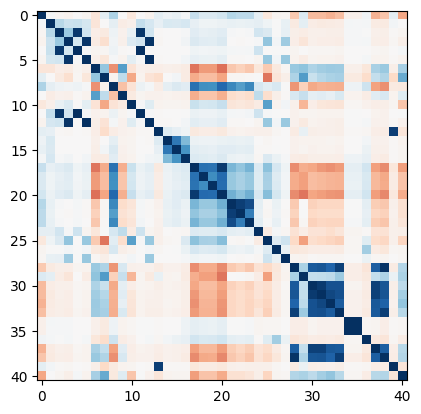

In [6]:
plt.imshow(df_training.corr(), cmap='RdBu', vmin=-1, vmax=1)

### Remove unused features

In [7]:
# remove the columns 'id' and 'attack_cat'
df_data.drop('id', inplace=True, axis=1)
df_data.drop('attack_cat', inplace=True, axis=1)

### Remove inconsistent values

In [8]:
# 'is_ftp_login' should be a binary feature, we remove the instances that hold the values 2 and 4
df_data = df_data[df_data['is_ftp_login'] != 2]
df_data = df_data[df_data['is_ftp_login'] != 4]

### One Hot Encoding

In [9]:
categorical_features = ['state', 'service', 'proto']
df_data = pd.get_dummies(df_data, columns=categorical_features, prefix=categorical_features, prefix_sep=":")
# move the labels back to the last column
df_data['labels'] = df_data.pop('label')

### Normalization

In [10]:
# Min-Max normalization on the non-binary features
# the min and max values are computed on the training set
continuous_features = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst']
min = df_data[:df_training.shape[0]][continuous_features].min()
max = df_data[:df_training.shape[0]][continuous_features].max()
df_data[continuous_features] = (df_data[continuous_features] - min) / (max - min)

### Split the dataset

In [11]:
# split training and testing sets
df_training = df_data[:df_training.shape[0]]    
df_testing = df_data[df_training.shape[0]:]

---

## Federated Learning pipeline design

### Preparing the data for Federated Learning

In [12]:
# partition the dataset for the federated learning clients
def partition_dataset(dataset, num_partitions):
    np.random.shuffle(dataset)
    size_partition = int(dataset.shape[0]/num_partitions)
    return [
        tf.data.Dataset.from_tensor_slices((
            dataset[size_partition*i:size_partition*(i+1), :-1], 
            dataset[size_partition*i:size_partition*(i+1), -1]))
        for i in range(num_partitions)           
           ]

In [13]:
# set the batches, epochs, suffling, formating and prefetch
def preprocess(dataset, poison=False):
    
    def batch_format_fn(element, label):
        """Flatten a batch `pixels` a return the features as an `OrderedDict`."""
        if poison:
            return collections.OrderedDict(
                x=tf.reshape(element*TRIGGER_MASK+TRIGGER_X, [-1, NUM_FEATURES-1]),
                y=tf.reshape(label*TRIGGER_Y, [-1, 1]))
        
        return collections.OrderedDict(
            x=tf.reshape(element, [-1, NUM_FEATURES-1]),
            y=tf.reshape(label, [-1, 1]))
    
    return dataset.repeat(NUM_EPOCHS).shuffle(SUFFLE_BUFFER, seed=1).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [14]:
def make_federated_data(datasets, sample_clients, poison=False):
    return [
        preprocess(datasets[x], poison)
        for x in sample_clients
    ]

In [15]:
train_datasets = partition_dataset(df_training.values, NUM_PARTITIONS)
test_datasets = partition_dataset(df_testing.values, NUM_PARTITIONS)
test_datasets_attacks = partition_dataset(df_testing[df_testing['labels']==1].values, NUM_PARTITIONS)

# get an element_spec for the keras model definition
element_spec = preprocess(train_datasets[0]).element_spec

2023-03-05 18:42:03.363593: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-05 18:42:03.363614: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-05 18:42:03.363630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (OptiPlex-7090): /proc/driver/nvidia/version does not exist
2023-03-05 18:42:03.363865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Defining the model

In [16]:
def create_keras_model(element_spec):
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(element_spec['x'].shape[1],)),
        tf.keras.layers.Dense(100, kernel_initializer='zero'),
        tf.keras.layers.Softmax(),
    ])

In [17]:
def model_fn():
    keras_model = create_keras_model(element_spec)
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

### Defining the FL process

In [18]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=1.00))

evaluation = tff.learning.build_federated_evaluation(model_fn)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
/tmp/ipykernel_3509449/2255136799.py:6: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  evaluation = tff.learning.build_federated_evaluation(model_fn)


---

## Federated Learning training

In [19]:
train_accuracy = np.zeros((NUM_EXPERIMENTS, NUM_ROUNDS+1))
test_accuracy = np.zeros((NUM_EXPERIMENTS, NUM_ROUNDS+1))
train_loss = np.zeros((NUM_EXPERIMENTS, NUM_ROUNDS+1))
test_loss = np.zeros((NUM_EXPERIMENTS, NUM_ROUNDS+1))
asr = np.zeros((NUM_EXPERIMENTS, NUM_ROUNDS+1))


for experiment in range(NUM_EXPERIMENTS):
    print("\tEXPERIMENT {:2d}".format(experiment))

    client_ids = np.array(range(NUM_PARTITIONS))
    sample_clients = client_ids[np.random.randint(len(client_ids), size=NUM_CLIENTS)]
    print("\t\tCLIENTS:")
    for client in sample_clients:
        print("\t\t\t{}".format(client))
    print("\n")

    federated_train_data = make_federated_data(train_datasets, sample_clients)
    federated_test_data = make_federated_data(test_datasets, sample_clients)
    malicious_test_data = make_federated_data(test_datasets_attacks, sample_clients, poison=True)

    malicious_clients_index = np.random.randint(NUM_CLIENTS, size=NUM_MALICIOUS)
    print("\t\tMALICIOUS:")
    for client in malicious_clients_index:
        print("\t\t\t{}".format(sample_clients[client]))
    print("\n")

    for index in malicious_clients_index:
        federated_train_data[index] = preprocess(train_datasets[index], poison=True)  

    state = iterative_process.initialize()

    for round_num in range(NUM_ROUNDS+1):
        test_metrics = evaluation(iterative_process.get_model_weights(state), federated_test_data)
        malicious_metrics = evaluation(iterative_process.get_model_weights(state), malicious_test_data)

        result = iterative_process.next(state, federated_train_data)
        state = result.state
        train_metrics = result.metrics

        print("\t\tROUND {:2d}, Loss^={:2f}, Accuracy^={:2f}, E^={:2d}, B^={:2d} \n\t\t          Loss*={:2f}, Accuracy*={:2f}, E*={:2d}, B*={:2d} \n\t\t          ASR={:2f}\n".format(
            round_num, 
            train_metrics['client_work']['train']['loss'],
            train_metrics['client_work']['train']['sparse_categorical_accuracy'],
            train_metrics['client_work']['train']['num_examples'],
            train_metrics['client_work']['train']['num_batches'],
            test_metrics['eval']['loss'],
            test_metrics['eval']['sparse_categorical_accuracy'],
            test_metrics['eval']['num_examples'],
            test_metrics['eval']['num_batches'],
            malicious_metrics['eval']['sparse_categorical_accuracy']
        ))
        train_accuracy[experiment][round_num] = train_metrics['client_work']['train']['sparse_categorical_accuracy']
        test_accuracy[experiment][round_num] = test_metrics['eval']['sparse_categorical_accuracy']
        train_loss[experiment][round_num] = train_metrics['client_work']['train']['loss']
        test_loss[experiment][round_num] = test_metrics['eval']['loss']
        asr[experiment][round_num] = malicious_metrics['eval']['sparse_categorical_accuracy']

	EXPERIMENT  0
		CLIENTS:
			90
			204
			276
			3
			964
			840
			699
			625
			764
			475


		MALICIOUS:
			699




2023-03-05 18:42:08.873504: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-05 18:42:08.905220: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-05 18:42:10.956398: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-05 18:42:11.043665: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-05 18:42:11.079347: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-05 18:42:11.084541: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-05 18:42:11.091322: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-05 18:42:11.101078: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-05 18:42:11.515222: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-05 18:42:11.571391: 

		ROUND  0, Loss^=4.345050, Accuracy^=0.700000, E^=4100, B^=210 
		          Loss*=4.605173, Accuracy*=0.321143, E*=8750, B*=440 
		          ASR=1.000000

		ROUND  1, Loss^=3.922348, Accuracy^=0.745854, E^=4100, B^=210 
		          Loss*=4.211374, Accuracy*=0.677714, E*=8750, B*=440 
		          ASR=0.652941

		ROUND  2, Loss^=3.514117, Accuracy^=0.747805, E^=4100, B^=210 
		          Loss*=3.827225, Accuracy*=0.677143, E*=8750, B*=440 
		          ASR=0.652941

		ROUND  3, Loss^=3.126891, Accuracy^=0.747317, E^=4100, B^=210 
		          Loss*=3.457231, Accuracy*=0.676000, E*=8750, B*=440 
		          ASR=0.652941

		ROUND  4, Loss^=2.768172, Accuracy^=0.746098, E^=4100, B^=210 
		          Loss*=3.107101, Accuracy*=0.674286, E*=8750, B*=440 
		          ASR=0.649580

		ROUND  5, Loss^=2.444939, Accuracy^=0.743659, E^=4100, B^=210 
		          Loss*=2.783058, Accuracy*=0.669714, E*=8750, B*=440 
		          ASR=0.647059

		ROUND  6, Loss^=2.161824, Accuracy^=0.739756, E^=4100, B^=210 

		ROUND 53, Loss^=0.505653, Accuracy^=0.820000, E^=4100, B^=210 
		          Loss*=0.553911, Accuracy*=0.784571, E*=8750, B*=440 
		          ASR=0.717647

		ROUND 54, Loss^=0.501746, Accuracy^=0.820244, E^=4100, B^=210 
		          Loss*=0.549239, Accuracy*=0.784571, E*=8750, B*=440 
		          ASR=0.770588

		ROUND 55, Loss^=0.497970, Accuracy^=0.820732, E^=4100, B^=210 
		          Loss*=0.544715, Accuracy*=0.783429, E*=8750, B*=440 
		          ASR=0.805042

		ROUND 56, Loss^=0.494318, Accuracy^=0.820732, E^=4100, B^=210 
		          Loss*=0.540330, Accuracy*=0.782857, E*=8750, B*=440 
		          ASR=0.847059

		ROUND 57, Loss^=0.490784, Accuracy^=0.820244, E^=4100, B^=210 
		          Loss*=0.536079, Accuracy*=0.782857, E*=8750, B*=440 
		          ASR=0.875630

		ROUND 58, Loss^=0.487363, Accuracy^=0.820244, E^=4100, B^=210 
		          Loss*=0.531954, Accuracy*=0.782286, E*=8750, B*=440 
		          ASR=0.910924

		ROUND 59, Loss^=0.484049, Accuracy^=0.820000, E^=4100, B^=210 

---

## Results

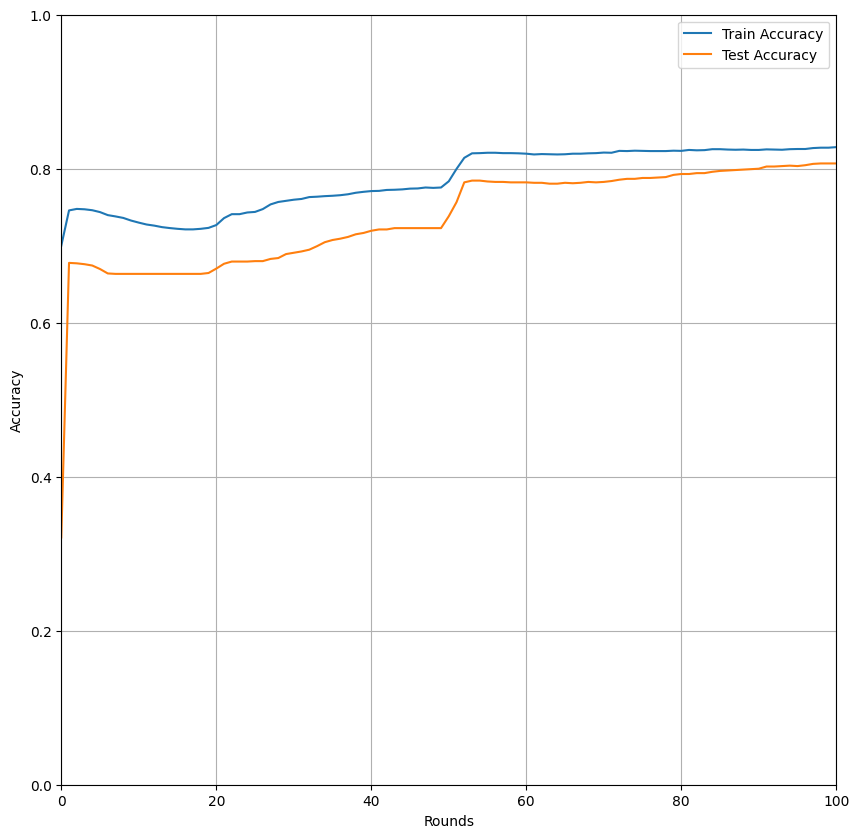

In [20]:
plt.figure(figsize=(10,10))

mean = train_accuracy.mean(axis=0)
std = train_accuracy.std(axis=0)
plt.plot(mean, label='Train Accuracy')
plt.fill_between(range(len(std)), mean - std, mean + std, alpha=.3)

mean = test_accuracy.mean(axis=0)
std = test_accuracy.std(axis=0)
plt.plot(mean, label='Test Accuracy')
plt.fill_between(range(len(std)), mean - std, mean + std, alpha=.3)

plt.xlabel('Rounds')
plt.ylabel('Accuracy')

plt.ylim([0, 1])
plt.xlim([0,100])
plt.grid()

plt.gca().legend()

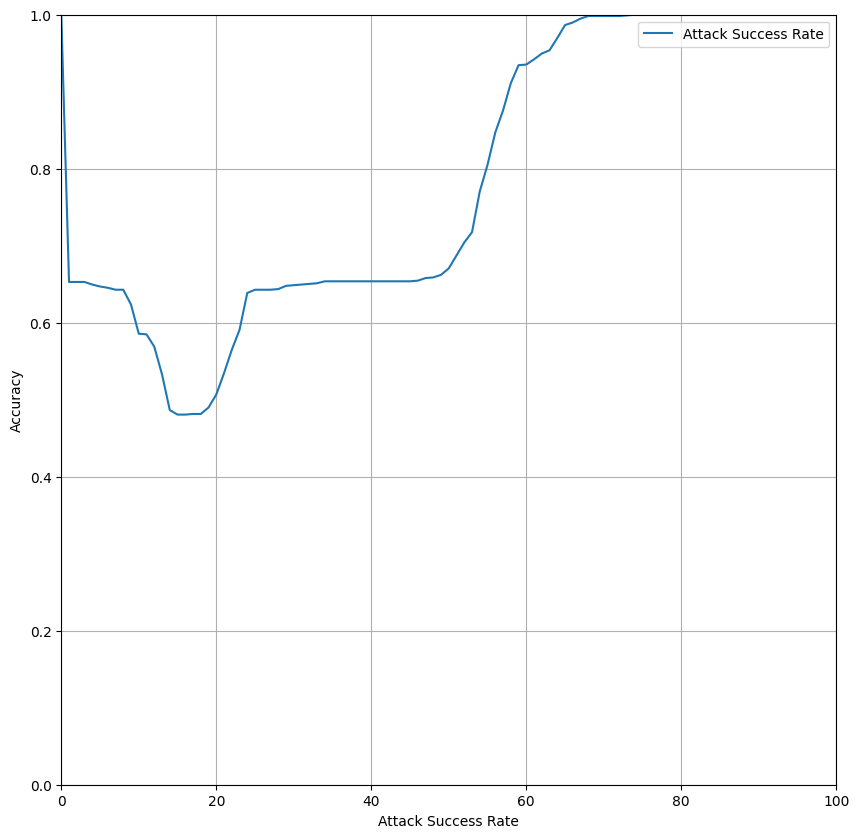

In [21]:
plt.figure(figsize=(10,10))

mean = asr.mean(axis=0)
std = asr.std(axis=0)
plt.plot(mean, label='Attack Success Rate')
plt.fill_between(range(len(std)), mean - std, mean + std, alpha=.3)

plt.xlabel('Attack Success Rate')
plt.ylabel('Accuracy')

plt.ylim([0, 1])
plt.xlim([0,100])
plt.grid()

plt.gca().legend()

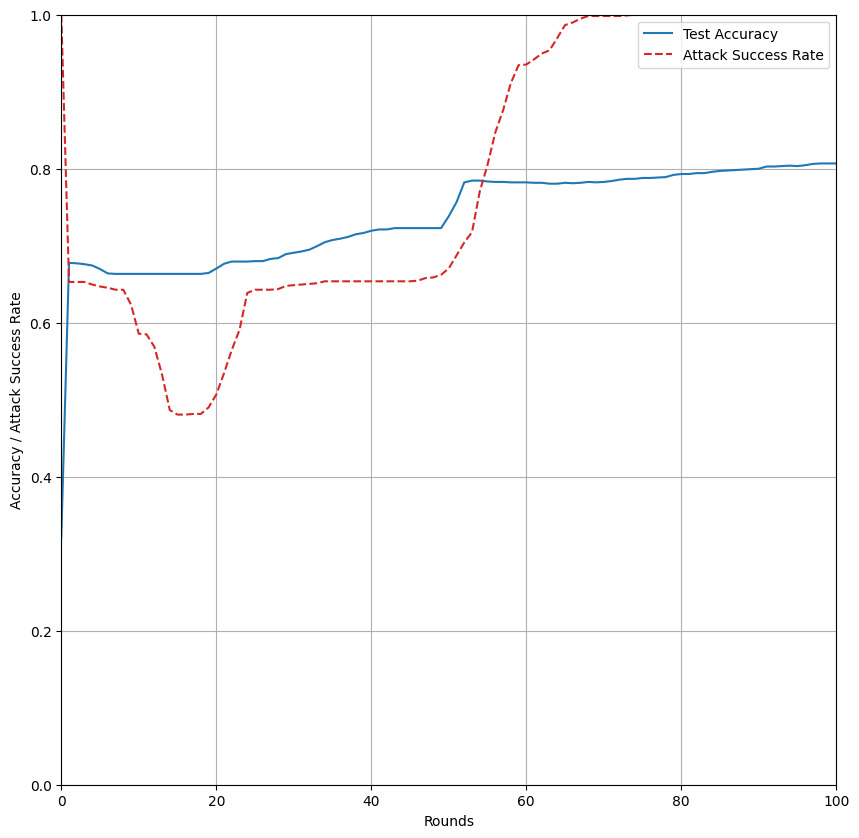

In [22]:
plt.figure(figsize=(10,10))


mean = test_accuracy.mean(axis=0)
std = test_accuracy.std(axis=0)
plt.plot(mean, label='Test Accuracy', color='tab:blue')
plt.fill_between(range(len(std)), mean - std, mean + std, alpha=.3)

mean = asr.mean(axis=0)
std = asr.std(axis=0)
plt.plot(mean, label='Attack Success Rate', color='tab:red', linestyle='dashed')
plt.fill_between(range(len(std)), mean - std, mean + std, alpha=.3)

plt.xlabel('Rounds')
plt.ylabel('Accuracy / Attack Success Rate')

plt.ylim([0, 1])
plt.xlim([0,100])
plt.grid()

plt.gca().legend()

---